In [3]:
import numpy as np
import pandas as pd

import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from scipy.stats import probplot, moment

import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
original_data_path = "../data/main.csv"
df = pd.read_csv(original_data_path)
df['date'] = pd.to_datetime(df['date'])
df.head()

,date,open,high,low,close,volume,average,barCount,negative,neutral,positive,DFF,DTB3,DGS10,DFII10,DGS1,DGS2,DGS5,DFII5,BAMLH0A0HYM2
0,2022-12-27,3986.00,3986.00,3986.00,3986.00,1.0,3986.00,1,0.096508,0.679061,0.224432,4.33,4.35,3.84,1.58,4.75,4.32,3.94,1.61,4.55
1,2022-12-28,3955.00,3955.00,3955.00,3955.00,1.0,3955.00,1,0.076432,0.660771,0.262796,4.33,4.35,3.88,1.60,4.71,4.31,3.97,1.64,4.77
2,2022-12-29,4015.00,4015.00,4009.00,4009.00,7.0,4011.15,5,0.065120,0.656600,0.278280,4.33,4.34,3.83,1.56,4.71,4.34,3.94,1.62,4.81
3,2022-12-30,3998.25,3998.25,3998.25,3998.25,0.0,3998.25,0,0.092447,0.629921,0.277632,4.33,4.30,3.88,1.58,4.73,4.41,3.99,1.66,4.79
4,2023-01-03,3982.00,3982.00,3982.00,3982.00,0.0,3982.00,0,0.084405,0.664180,0.251415,4.33,4.40,3.79,1.53,4.72,4.40,3.94,1.65,4.70


In [16]:
series = df['close'].squeeze().dropna()
series

0      3986.00
1      3955.00
2      4009.00
3      3998.25
4      3982.00
        ...   
299    5157.25
300    5132.00
301    5128.25
302    5175.00
303    5172.50
Name: close, Length: 304, dtype: float64

In [28]:
# plot series
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=df['date'], y=series, mode='lines', name='close'))
fig.update_layout(title='Close Price', xaxis_title='Date', yaxis_title='Price')
fig.show()

In [33]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller    
    
def ADF(series):
    result = adfuller(series, autolag='AIC')
    adf_statistic, p_value, usedlag, nobs, critical_values, icbest = result
    print(f'ADF Statistic: {adf_statistic}')
    print(f'p-value: {p_value}')
    print('Critical Values:')
    is_stationary = False
    for key, value in critical_values.items():
        print(f'   {key}: {value}')
    if p_value <= 0.05:
        print("Evidence suggests that the time series is stationary.")
        is_stationary = True
    else:
        print("Evidence suggests that the time series is not stationary.")
        
    # Build a dictionary to return the results
    adf_result = {
        'adf_statistic': adf_statistic,
        'p_value': p_value,
        'usedlag': usedlag,
        'nobs': nobs,
        'critical_values': critical_values,
        'icbest': icbest,
        'is_stationary': is_stationary
    }
    
    return adf_result

ADF(series)       

ADF Statistic: -0.455155051730635
p-value: 0.900474622432051
Critical Values:
   1%: -3.4521175397304784
   5%: -2.8711265007266666
   10%: -2.571877823851692
Evidence suggests that the time series is not stationary.


{'adf_statistic': -0.455155051730635,
 'p_value': 0.900474622432051,
 'usedlag': 0,
 'nobs': 303,
 'critical_values': {'1%': -3.4521175397304784,
  '5%': -2.8711265007266666,
  '10%': -2.571877823851692},
 'icbest': 2862.830830778232,
 'is_stationary': False}

In [38]:
# First order differencing
diff = series.diff().dropna()
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['date'][1:], y=diff, name='close', mode='markers'))
fig.update_layout(title='Close Price', xaxis_title='Date', yaxis_title='Price')
fig.show()

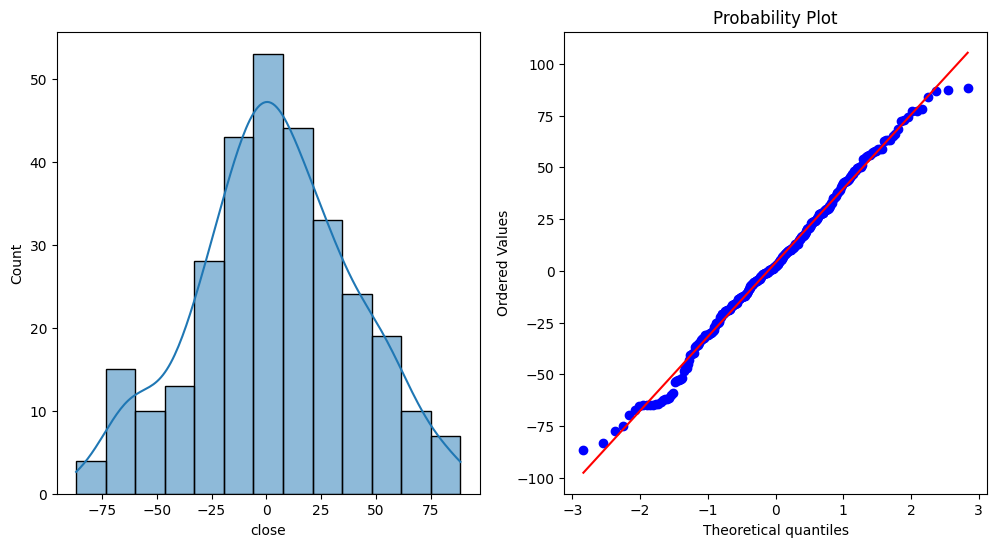

In [39]:
# distribution of the differenced series
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.histplot(diff, kde=True, ax=ax[0])
probplot(diff, plot=ax[1])
plt.show()

In [35]:
ADF(diff)

ADF Statistic: -13.14793083473656
p-value: 1.3859166827159074e-24
Critical Values:
   1%: -3.452263435801039
   5%: -2.871190526189069
   10%: -2.571911967527952
Evidence suggests that the time series is stationary.


{'adf_statistic': -13.14793083473656,
 'p_value': 1.3859166827159074e-24,
 'usedlag': 1,
 'nobs': 301,
 'critical_values': {'1%': -3.452263435801039,
  '5%': -2.871190526189069,
  '10%': -2.571911967527952},
 'icbest': 2851.6121703158155,
 'is_stationary': True}

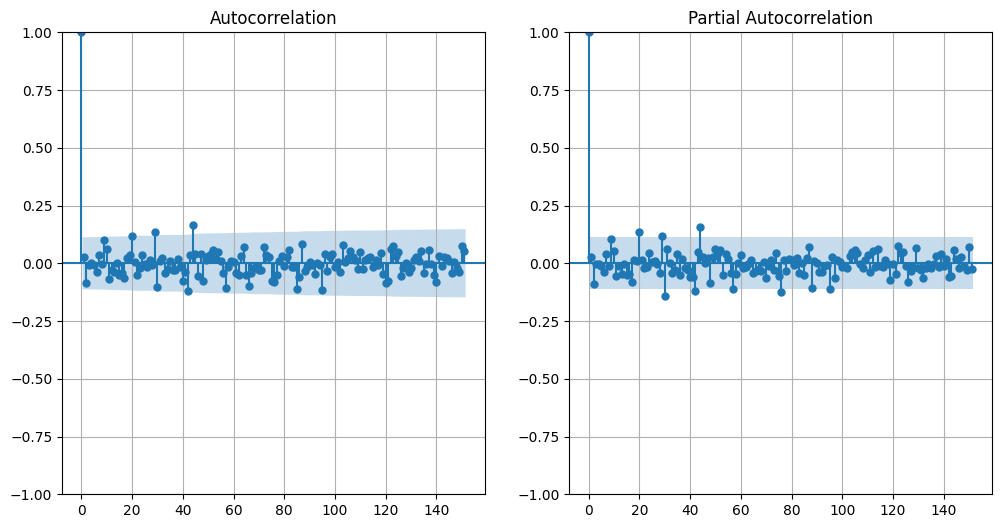

In [51]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ACF and PACF
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
plot_acf(diff, ax=ax[0], lags=151)
plot_pacf(diff, ax=ax[1], lags=151)
# grid
for a in ax:
    a.grid(True)
plt.show()

In [52]:
from statsmodels.tsa.stattools import acf, pacf

# Calculate ACF and PACF
acf_values = acf(diff, nlags=151)
pacf_values = pacf(diff, nlags=151)

# Determine the confidence interval for significance
# For a 95% confidence interval, the cutoff is approximately +/- 1.96/sqrt(N)
# where N is the number of observations
conf_interval = 1.96 / (len(diff)**0.5)

# Identify significant lags
significant_acf_lags = [i for i in range(len(acf_values)) if abs(acf_values[i]) > conf_interval]
significant_pacf_lags = [i for i in range(len(pacf_values)) if abs(pacf_values[i]) > conf_interval]

# Exclude the zero lag
significant_acf_lags = significant_acf_lags[1:]
significant_pacf_lags = significant_pacf_lags[1:]

print('Significant ACF lags:', significant_acf_lags)
print('Significant PACF lags:', significant_pacf_lags)

Significant ACF lags: [20, 29, 42, 44, 95]
Significant PACF lags: [20, 29, 30, 42, 44, 57, 76, 88, 95, 114, 119, 122, 124, 126, 129, 132, 142, 143, 144, 147, 150, 151]
